### Group Members:

- Name, matriculation number
- Name, matriculation number
- Name, matriculation number

# Assignment 3 - Convolutional Network and Transfer Learning

The goal of this exercise is to learn how to train a small convolutional neural network (CNN) and fine-tune this trained network in transfer learning tasks.

Our CNN has the following layers:

1. 2D convolutional layer with $Q_1$ channels, kernel size $7\times7$, stride 1 and padding 0.
2. 2D maximum pooling with pooling size $2\times2$ and stride 2
3. `Tanh` activation
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. 2D maximum pooling with pooling size $2\times2$ and stride 2
6. `Tanh` activation
7. A flattening layer to turn the 3D image into a 1D vector
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

For this exercise, we will switch to an implementation in `PyTorch`.
We will get used to some concepts in `PyTorch`, such as relying on the `torch.tensor` data structure, implementing the network, the loss functions, the training loop, and accuracy computation, which we will apply to categorical classification.
We will see how backpropagation and weight update will be done automatically by `torch`.

Please make sure that all your variables are compatible with `torch`.
For example, you cannot mix `torch.tensor`s and `numpy.array`s in any part of the code.

The CNN will be trained on the `letters` from EMNIST datasets and fine-tuned with the `digits` from the same dataset.

## Coding


**<font color='red' size='5'>This section has to be submitted by 11:59 p.m. on Wednesday, April 9, to be graded.</font>**

Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [1]:
import torch
import torchvision

if torch.cuda.is_available():
    print("Successfully enabled CUDA processing")
    device = torch.device("cuda")
else:
    print("CUDA processing not available. Things will be slow :-(")
    device = torch.device("cpu")

Successfully enabled CUDA processing


### Dataset

In PyTorch, a dataset stores a list of input and target tensors $(X^{[n]}, T^{[n]})$.
We will make use of EMNIST dataset for this assignment.
In particular, we will use the letters to train the CNN for classification task and then fine-tune this CNN using the digits.

In the **EMNIST** dataset, the inputs are $X^{[n]} \in \mathbb R^{28\times28}$.
In case of the `letters` split, the labels are $T^{[n]} \in \{1,\ldots,26\}$.
For `digits` split, the labels $T^{[n]} \in \{0,\ldots,9\}$ correspond to the digit.

More precisely, the data in the dataset is provided in the form of `PIL.Image.Image`, which represents an image class with some more functionality, and pixel values in range $[0, 255]$.
To convert these images into `torch.Tensor`'s in range $[0,1]$, we can use the `torchvision.transforms.ToTensor` transform.
Furthermore, in `PyTorch` batches are created from datasets using the `torch.utils.data.DataLoader` class.

#### Task 2.1: Dataset Loading

Here, we use the letters (`split="letters"`) in EMNIST dataset of gray images for categorical classification, and digits (`split="digits"`) for transfer learning.

Write a function that returns the training and the validation set of the dataset, using the given `transform` and `split`.

Note:

Targets for `letters` range $[1,26]$ by default, which will cause problem when using the loss desired function (which accepts $[0,25]$ instead) in `PyTorch`.
Set `target_transform` to a function that can shift the target by subtracting 1 when `split="letters".`

In [4]:
def datasets(split,transform):

    if split == "letters":
        # apply lambda function to change the range of target from [1,26] to [0,25]
        target_transform = lambda y: y - 1
    else:
        target_transform = None

    trainset = torchvision.datasets.EMNIST(root="./data", split=split, transform=transform, target_transform=target_transform, download=True)
    validset = torchvision.datasets.EMNIST(root="./data", split=split, train=False, transform=transform, target_transform=target_transform, download=True)

    return trainset, validset

#### Test 1: Data Types

Create the dataset with `transform=None`.
Check that all inputs are of type `PIL.Image.Image`, and all targets are integral.

In [5]:
import PIL
splits = ["letters","digits"]
for split in splits:
    trainset, validset = datasets(split=split,transform=None)

    for x,t in trainset:
        # check datatype of input x
        assert isinstance(x, PIL.Image.Image)
        # check datatype of target t
        assert isinstance(t, int)

100%|██████████| 562M/562M [00:14<00:00, 38.1MB/s]


#### Task 2.2: Data Visulization
Create the dataset with `transform=None`.
Use `matplotlib` to make a plot with 4 rows and 10 columns.

Since all images in EMNIST dataset have been encoded with mixed-up horizontal and vertical axes, we want to plot the original image, as well as the version with a fixed orientation.

Specifically, in the first row plot 10 images of letter trainset, and in the second row, plot them again with correct orientation. In the third row plot 10 images of digit trainset, and in the fourth row, plot them again with correct orientation.

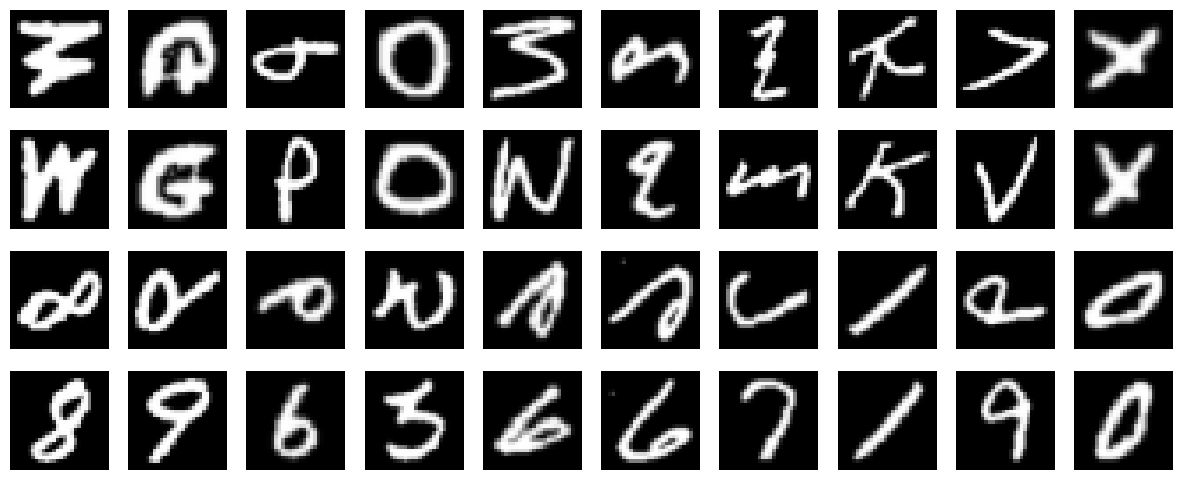

In [8]:
# Load dataset without transformation (to show original)
train_letters, _ = datasets(split="letters",transform=None)
train_digits, _ = datasets(split="digits",transform=None)


import numpy as np
from matplotlib import pyplot

pyplot.rcParams['image.cmap'] = 'gray'

# Function to fix exchanged horizontal and vertical axes
def fix_orientation(img):
    return np.array(img).T

# Visualization
fig, axes = pyplot.subplots(4, 10, figsize=(15, 6))

# Select 10 samples
index = 0
for j in range(10):
    # Load letter
    img_letter, _ = train_letters[j]
    fixed_letter = fix_orientation(img_letter)

    # Load digit
    img_digit, _ = train_digits[j]
    fixed_digit = fix_orientation(img_digit)

    # Plot raw and fixed letters
    axes[0, j].imshow(img_letter)
    axes[1, j].imshow(fixed_letter)

    # Plot raw and fixed digits
    axes[2, j].imshow(img_digit)
    axes[3, j].imshow(fixed_digit)

    # Remove axes
    for i in range(4):
        axes[i, j].axis("off")

    index += 1

pyplot.show()


#### Task 2.3: Data Loaders

Create two datasets by two splits with `transform=torchvision.transforms.ToTensor()`.
For each dataset, create two data loaders, one for the training set and one for the validation set.
The training batch size should be $B=64$, for the validation set, you can choose any batch size of your choice.

In [9]:
transform = torchvision.transforms.ToTensor()
trainset_letters, validset_letters = datasets(split="letters",transform=transform)
trainset_digits, validset_digits = datasets(split="digits",transform=transform)

B = 64

trainloader_letters = torch.utils.data.DataLoader(trainset_letters, batch_size=B, shuffle=True)
validloader_letters = torch.utils.data.DataLoader(validset_letters, batch_size=128, shuffle=False)

trainloader_digits = torch.utils.data.DataLoader(trainset_digits, batch_size=B, shuffle=True)
validloader_digits = torch.utils.data.DataLoader(validset_digits, batch_size=128, shuffle=False)

#### Test 2: Batches

Check that all inputs and targets are of type `torch.Tensor`.

Check that all input values are in range $[0,1]$.

Check that all target values are in range $[0,25]$ for letters and $[0,9]$ for digits.

In [10]:
for x,t in trainloader_letters:
    # check datatype, size and content of x
    assert isinstance(x, torch.Tensor)
    assert torch.all(x >= 0) and torch.all(x <= 1)
    # check datatype, size and content of t
    assert isinstance(t, torch.Tensor)
    assert torch.all(t >= 0) and torch.all(t <= 25)


for x,t in trainloader_digits:
    # check datatype, size and content of x
    assert isinstance(x, torch.Tensor)
    assert torch.all(x >= 0) and torch.all(x <= 1)

    # check datatype, size and content of t
    assert isinstance(t, torch.Tensor)
    assert torch.all(t >= 0) and torch.all(t <= 9)

### Convolutional Network Training

For training and evaluating the network, we will rely on standard functionality in PyTorch.
We will use the standard categorical cross-entropy loss together with a stochastic gradient descent optimizer.
For training, we will use the batched implementation of the dataset, for which we perform one update step for each training batch.

For each epoch, we will compute and save the average loss and accuracy for the full training set and validation set.
This will be used to visualize the training process of CNN.

#### Task 2.4: Training and Validation Loop


Implement a function that takes the network, train loader, validation loader, the number of epochs, the learning rate, and the momentum.
Select the correct loss function for categorical classification and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data.
2. Compute the train set loss, train set accuracy, validation set loss, validation set accuracy.
3. Store all in lists, for later visualization of CNN training process.

Finally, return the lists of train losses and accuracies, as well as validation losses and accuracies.

Notes:

- Make sure that you train on the training data only, and `not` on the validation data.

- When you iterate over validation set, please use `with torch.no_grad():` and loop on validloader inside it. This disables gradient computation and therefore saves memory.

- While saving loss values, please use `.item()`.

- Make sure that you divide the summed loss and accuracy values by the correct count.

In [12]:
def training_loop(network, trainloader, validloader, epochs, lr, momentum):

    network.to(device)

    # select loss function and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=momentum)

    # collect loss values and accuracies over the training epochs
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []

    for epoch in range(epochs):
        # train network on training data
        train_loss, train_correct, train_total = 0, 0, 0
        for x, t in trainloader:
            # put data to device
            x, t = x.to(device), t.to(device)

            # train
            optimizer.zero_grad()
            output = network(x)
            loss = loss_function(output, t)
            loss.backward()

            # weight update
            optimizer.step()

            # calculate training accuracies and losses for current batch
            train_loss += loss.item() * x.size(0)
            _, predicted = torch.max(output.data, 1)
            train_total += t.size(0)
            train_correct += (predicted == t).sum().item()

        # append training accuracies and losses for current epoch
        train_loss_list.append(train_loss / train_total)
        train_acc_list.append(train_correct / train_total)

        # validate network on validation data
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for x, t in validloader:
                # put data to device
                x, t = x.to(device), t.to(device)

                # compute validation loss
                output = network(x)
                loss = loss_function(output, t)
                val_loss += loss.item() * x.size(0)

                # compute validation accuracy
                _, predicted = torch.max(output.data, 1)
                val_total += t.size(0)
                val_correct += (predicted == t).sum().item()

        # append validation accuracies and losses for current epoch
        val_loss_list.append(val_loss / val_total)
        val_acc_list.append(val_correct / val_total)

        # print training loss, accuracy, validation loss, accuracy for current epoch
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss_list[-1]:.4f} | Train Acc: {train_acc_list[-1]*100:.2f}% | "
              f"Val Loss: {val_loss_list[-1]:.4f} | Val Acc: {val_acc_list[-1]*100:.2f}%")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

#### Task 2.5: Convolutional Network

We will rely on `torch.nn.Sequential` to create networks with particular lists of consecutive layers.

Implement a function that generates a convolutional network with the following layers:

1. 2D convolutional layer with $Q_1$ channels, kernel size $7\times7$, stride 1 and padding 0.
2. 2D maximum pooling with pooling size $2\times2$ and stride 2
3. `tanh` activation
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. 2D maximum pooling with pooling size $2\times2$ and stride 2
6. `tanh` activation
7. A flattening layer to turn the 3D feature map into a 1D vector
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [15]:
def convolutional(Q1, Q2, O):
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, Q1, kernel_size=7, stride=1, padding=0),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Tanh(),

        torch.nn.Conv2d(Q1, Q2, kernel_size=5, stride=1, padding=2),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Tanh(),
        torch.nn.Flatten(),

        torch.nn.Linear(Q2 * 5 * 5, O)

    )

#### Test 3: Network Implementation

Create a network with an arbitrary shape.

Create a batch that follows input dimensions.

Forward the batch through the network.

Check that the output dimensions fit.

In [16]:
net_ = convolutional(3,4,6)
batch_ = torch.rand((8,1,28,28))
output_ = net_(batch_)
assert output_.shape == (8,6)

#### Task 2.6: Convolutional Training

Create a convolutional network with $Q_1=16$ and $Q_2=16$ convolutional channels and $O=26$ output neurons.
Train the network for 5 epochs with $\eta=0.01$, $\text{momentum}=0.9$ and store the obtained train losses, accuracies, test losses and accuracies.

If you want, you can also train for 20 epochs, the training time will increase accordingly -- it might take up to 30 minutes.

In [17]:
initial_network = convolutional(16, 16, 26)
train_loss, train_acc, val_loss, val_acc = training_loop(initial_network, trainloader_letters, validloader_letters, epochs=5, lr=0.01, momentum=0.9)

Epoch [1/5] | Train Loss: 0.6696 | Train Acc: 80.38% | Val Loss: 0.3604 | Val Acc: 89.08%
Epoch [2/5] | Train Loss: 0.3188 | Train Acc: 90.07% | Val Loss: 0.3182 | Val Acc: 90.19%
Epoch [3/5] | Train Loss: 0.2752 | Train Acc: 91.27% | Val Loss: 0.2797 | Val Acc: 91.17%
Epoch [4/5] | Train Loss: 0.2523 | Train Acc: 91.91% | Val Loss: 0.2707 | Val Acc: 91.20%
Epoch [5/5] | Train Loss: 0.2383 | Train Acc: 92.31% | Val Loss: 0.2626 | Val Acc: 91.76%


#### Task 2.7: Plotting

Plot the loss values in one plot and accuracy values into another plot.

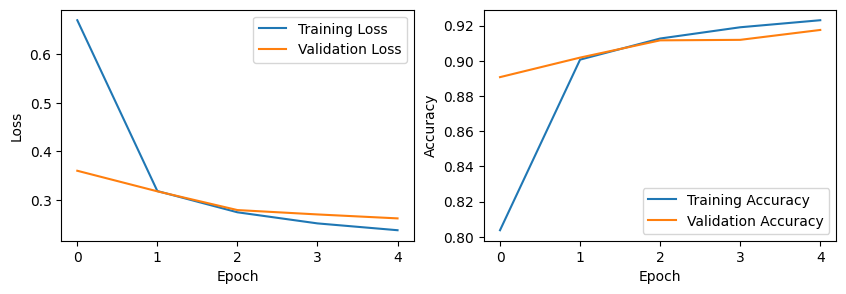

In [18]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))

ax = pyplot.subplot(121)
# plot training and validation loss values of CV network over epochs
pyplot.plot(train_loss, label='Training Loss')
pyplot.plot(val_loss, label='Validation Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()

ax = pyplot.subplot(122)
# plot training and validation accuracy values of CV network over epochs
pyplot.plot(train_acc, label='Training Accuracy')
pyplot.plot(val_acc, label='Validation Accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.legend()

pyplot.show()

### Transfer Learning

We will make use of above trained CNN, which can be used to classify 26 handwritten characters, and fine-tune this CNN as to the digits classification task instead.

#### Task 2.8: Pre-trained Network Instantiation

Make a copy of the trained CNN.

Freeze the feature layers of the copied network.

Notes:

- To freeze layers, you can simply disable gradient computation for all learnable parameters of the network via `parameter.requires_grad = False`.

In [19]:
import copy
# copy trained convolutional network
network_copy = copy.deepcopy(initial_network)

# Make sure to freeze all the layers of the network.
for param in network_copy.parameters():
    param.requires_grad = False

#### Task 2.9: Network Implementation

We want to modify the network such that we extract the logits for the 10 classes from the last fully-connected layer of the network.

Implement a function that replaces the current last linear layer of the pre-trained network with a new linear layer that has $O$ units ($O$ represents the number of classes in our dataset).

In [20]:
def replace_last_layer(network, O=10):
    # replace the last linear layer with a new layer
    network[-1] = torch.nn.Linear(network[-1].in_features, O)

    return network

#### Test 4: Last Layer Dimensions

This test ensures that the function return a network having the correct number of input and output units in the last layer.

In [21]:
O = 6

_test_network = replace_last_layer(network_copy, O=O)
assert _test_network[-1].out_features == O
assert _test_network[-1].in_features == 400

#### Task 2.10: Network Fine-Tuning with Frozen Layers

Create a network that has feature layers frozen with $10$ output units.
Fine-tune the created network for 2 epochs on our digits data (`trainloader_digits, validloader_digits`) using the previous function, and a smaller learning rate of $\eta=0.001$.

In [22]:
network_with_frozen_layers = replace_last_layer(network_copy, O=10)
_ = training_loop(network_with_frozen_layers, trainloader_digits, validloader_digits, epochs=2, lr=0.001, momentum=0.9)

Epoch [1/2] | Train Loss: 0.1469 | Train Acc: 96.69% | Val Loss: 0.0778 | Val Acc: 97.92%
Epoch [2/2] | Train Loss: 0.0688 | Train Acc: 98.23% | Val Loss: 0.0609 | Val Acc: 98.32%


#### Test 5: Frozen Layers

Check that all layers of the fine-tuned network that contain weights and biases (except for the last fully-connected layer) have not been modified by the training.

In [23]:
for i in range(len(initial_network)-1):
    if hasattr(initial_network[i], "weight"):
        assert torch.allclose(initial_network[i].weight, network_with_frozen_layers[i].weight)
    if hasattr(initial_network[i], "bias"):
        assert torch.allclose(initial_network[i].bias, network_with_frozen_layers[i].bias)

#### Task 2.11: Test Set Predictions

Go over the validation set of the Digits dataset once again and extract predictions of the network.

In [25]:
predictions = []
with torch.no_grad():
    for x, t in validloader_digits:
        # put data onto device
        x = x.to(device)

        # extract logits from the network
        logits = network_with_frozen_layers(x)

        # obtain predicted class
        predicted_class = torch.argmax(logits, dim=1)

        # store predicted class
        predictions.extend(predicted_class.cpu().tolist())

targets = [t for _,t in validset_digits]

#### Task 2.12: Confusion Matrix Plotting

Finally, we want to plot the confusion matrix of the validation set.
For this, we can make use of the `sklearn.metrics.confusion_matrix` to compute the confusion matrix.
You can utilize `sklearn.metrics.ConfusionMatrixDisplay` for displaying the confusion matrix, or `pyplot.imshow` and adding the according labels.

Note:

  * The documentation for the confusion matrix can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  * The interface and an example for the `ConfusionMatrixDisplay` can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

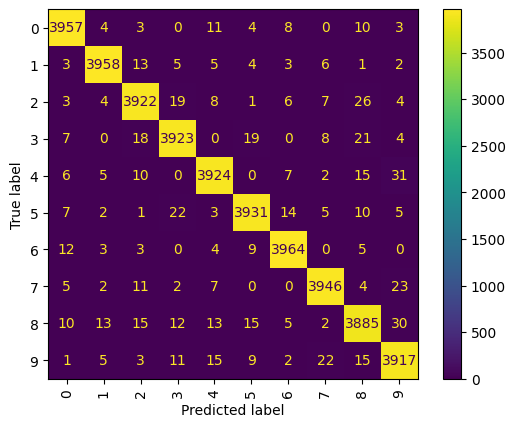

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# get the target class names
classes = trainset_digits.classes

# compute confusion matrix
matrix = confusion_matrix(targets, predictions) # Use predictions and target from the fine-tuned network

# plot confusion matrices
plot_conf_matrix1 = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes)
plot_conf_matrix1.plot(xticks_rotation = "vertical")
plt.show()